# Protein Embedding #

In this project we will focus on `protein_embedding` by using one of the two methods:

* `GAE` - Graph Auto Encoder

*  `struc2vec`

Important references for that project : 

* *BioNEV GitHub site* - that github site contains lot of inforamtion that required for that project(such as code, explanations and running examples):

https://github.com/xiangyue9607/BioNEV/tree/master

* *Graph embedding on biomedical network* - an article about graph embedding and methods (such as `GAE` and `struc2vec`) : 

https://academic.oup.com/bioinformatics/article/36/4/1241/5581350?login=false

*  *STRING PPI* - site that contains the data we are going to work with in that project:

https://version-11-0.string-db.org/cgi/input.pl?sessionId=8aVJal1k2wit&input_page_show_search=on

## Import Libraries ##

The first step in the project is to import some libraries that important for the next steps leading 
to the final that, graph embedding.

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib
import csv
import random
import warnings
import requests
import shutil
warnings.filterwarnings('ignore')

In [3]:
def PRINT_():
    print('#' *80)

## Downloading the data set from STRING PPI ##

Downloading the protein interaction data set versio `11.0` from *STRING PPI* as `.txt` file, and converting that into `.csv` 

In [4]:
# URL of the file to download
url = "https://stringdb-static.org/download/protein.links.v11.0/9606.protein.links.v11.0.txt.gz"

# Define the local file name
local_file_name = "9606.protein.links.v11.0.txt.gz"

# Send an HTTP GET request to the URL
response = requests.get(url, stream=True)

# Check if the request was successful
if response.status_code == 200:
    # Open the local file in binary write mode
    with open(local_file_name, 'wb') as local_file:
        # Iterate through the response content and write it to the local file
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                local_file.write(chunk)
else:
    print("Failed to download the file. HTTP status code:", response.status_code)

# Close the response
response.close()

After downloading the dataset from STRING PPI, the next step will be to extract the `.txt` file from it and convert
that file into `.csv` file

In [9]:
import gzip
import shutil

# Define the file names
gzip_file_name = '9606.protein.links.v11.0.txt.gz'
extracted_file_name = '9606.protein.links.v11.0.txt'

# Extract the contents of the gzip file
with gzip.open(gzip_file_name, 'rb') as f_in:
    with open(extracted_file_name, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File '{extracted_file_name}' has been extracted.")


File '9606.protein.links.v11.0.txt' has been extracted.


In [10]:
import pandas as pd

# Load the data from the .txt file
df = pd.read_csv('9606.protein.links.v11.0.txt', sep=' ')

# Convert it to a .csv file
df.to_csv('9606.protein.links.v11.0.csv', index=False)
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167
...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,167
11759450,9606.ENSP00000485678,9606.ENSP00000342448,175
11759451,9606.ENSP00000485678,9606.ENSP00000350222,195
11759452,9606.ENSP00000485678,9606.ENSP00000367590,900


In [11]:
len(df)

11759454

The next step is createing a `.txt` file to see if there are duplicated pairs of `protein1` and `protein2` and `combined_score` in the dataset

In [6]:
output_file = 'proteins_check.txt'
input_file = '9606.protein.links.v11.0.csv'
# Open the input CSV file and the output text file
with open(input_file, 'r') as csv_file, open(output_file, 'w') as txt_file:
    csv_reader = csv.DictReader(csv_file)
    
    # Write the header to the output text file
    txt_file.write(f"'protein1' 'protein2' 'combined_score\n")
    
    # Iterate through the rows in the CSV and write them to the text file
    for row in csv_reader:
        txt_file.write(f"{row['protein1']} {row['protein2']} {row['combined_score']}\n")

PRINT_()
print("Conversion complete. The text file has been created.")
PRINT_()

################################################################################
Conversion complete. The text file has been created.
################################################################################


## Data Cleaning ##

The next steps will be data cleaning steps, that will make sure our data is ready for the next
steps, and finally for the graph embedding method.

### Normalize the values of 'combined_score' to be in the range of 0-1 ###

In [7]:
# View the min& max values of the column 'combined_score':

max_value = df['combined_score'].max()
min_value = df['combined_score'].min()

PRINT_()
print(f"The maximum value of the column 'combined_score' is -> {max_value}, or {max_value/10}%")
print(f"The minimum value of the column 'combined_score is -> {min_value} or {min_value/10}%")
PRINT_()

################################################################################
The maximum value of the column 'combined_score' is -> 999, or 99.9%
The minimum value of the column 'combined_score is -> 150 or 15.0%
################################################################################


In [8]:
# Normalize the 'combined_score' column to the range 0-1
# Extract the 'combined_score' column
combined_score = df['combined_score']

df['combined_score'] = (combined_score - min_value) / (max_value - min_value)

print(len(df))

11759454


In [9]:
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,0.400471
1,9606.ENSP00000000233,9606.ENSP00000253401,0.056537
2,9606.ENSP00000000233,9606.ENSP00000401445,0.010601
3,9606.ENSP00000000233,9606.ENSP00000418915,0.537102
4,9606.ENSP00000000233,9606.ENSP00000327801,0.020024
...,...,...,...
11759449,9606.ENSP00000485678,9606.ENSP00000310488,0.020024
11759450,9606.ENSP00000485678,9606.ENSP00000342448,0.029446
11759451,9606.ENSP00000485678,9606.ENSP00000350222,0.053004
11759452,9606.ENSP00000485678,9606.ENSP00000367590,0.883392


In [10]:
# Create a set of unique proteins by combining both columns
unique_proteins = set(df['protein1']).union(df['protein2'])

# Count the unique proteins
unique_protein_count = len(unique_proteins)

PRINT_() 
print(f"The number of unique proteins in the data set of version 11.0 is -> {unique_protein_count}")
print(f"The number of unique proteins if the data set of version 10.5 is -> 15131")
print(f"There are {unique_protein_count - 15131} new unique proteins in the 11.0 version of STRING PPI")
PRINT_() 

################################################################################
The number of unique proteins in the data set of version 11.0 is -> 19354
The number of unique proteins if the data set of version 10.5 is -> 15131
There are 4223 new unique proteins in the 11.0 version of STRING PPI
################################################################################


In [11]:
PRINT_() 
print(f"Nex maximum of the column 'combined_score' is -> {df['combined_score'].max()}")
print(f"New minimum of the column 'combied_score' is -> {df['combined_score'].min()}")
PRINT_()

################################################################################
Nex maximum of the column 'combined_score' is -> 1.0
New minimum of the column 'combied_score' is -> 0.0
################################################################################


### Drop all the values that their 'combined_score' is under 0.7 ###

Before we move on, we will want to work only with sets of proteins that their
`combined_socore` in the range of `0.7-1.0`. 
Therefore, we will need to drop all the values that their `combined_score < 0.7`

In [12]:
number_of_rows_before_dropping = len(df)
# Drop rows where 'combined_score' is less than 0.7
df = df[df['combined_score'] >= 0.7]

# Reset the index if you want to keep it continuous
df.reset_index(drop=True, inplace=True)

unique_proteins_after_dropping = len(set(df['protein1']).union(df['protein2']))

In [13]:
PRINT_() 
print(f"The number of rows before dropping the rows with `combined_values` < 0.7 -> [{number_of_rows_before_dropping}]")
print(f"The number of rows after dropping the rows with 'combined_score` < 0.7 are -> [{len(df)}]")
print(f"Got rid of -> [{number_of_rows_before_dropping - len(df)}] values in total, that is {((((number_of_rows_before_dropping - len(df))/number_of_rows_before_dropping))*100):.2f}% of the total data")
PRINT_() 
print(f"The number of unique proteins before dropping is -> {len(unique_proteins)}")
print(f"The number of unique proteins after dropping is -> {unique_proteins_after_dropping}")
print(f"Dropped {len(unique_proteins) - unique_proteins_after_dropping} unique proteins")
PRINT_() 

################################################################################
The number of rows before dropping the rows with `combined_values` < 0.7 -> [11759454]
The number of rows after dropping the rows with 'combined_score` < 0.7 are -> [779364]
Got rid of -> [10980090] values in total, that is 93.37% of the total data
################################################################################
The number of unique proteins before dropping is -> 19354
The number of unique proteins after dropping is -> 16063
Dropped 3291 unique proteins
################################################################################


In [14]:
df

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000432568,0.893993
1,9606.ENSP00000000233,9606.ENSP00000427900,0.895171
2,9606.ENSP00000000233,9606.ENSP00000350199,0.707892
3,9606.ENSP00000000233,9606.ENSP00000354878,0.895171
4,9606.ENSP00000000233,9606.ENSP00000405926,0.890459
...,...,...,...
779359,9606.ENSP00000485678,9606.ENSP00000438346,0.883392
779360,9606.ENSP00000485678,9606.ENSP00000303482,0.883392
779361,9606.ENSP00000485678,9606.ENSP00000481878,0.883392
779362,9606.ENSP00000485678,9606.ENSP00000296142,0.883392


### Remove duplicated rows from the data ###

The next step is remove duplicated rows in our data set.
The idea is if `protein1` and `protein2` appear in our data which means that there are edge between them, and *also* there is a row with the same values of `protein1` and `protein2` but in different order, remove that duplicated row to reduce data.

In [15]:
num_of_rows_before_drop = len(df)

# Create a new DataFrame with sorted tuples of 'protein1' and 'protein2'
df['sorted_nodes'] = df.apply(lambda row: tuple(sorted([row['protein1'], row['protein2']])), axis=1)

# Use .loc to drop duplicates while preserving the first occurrence
df = df.loc[df.duplicated(subset=['sorted_nodes'], keep='first')]

# Drop the 'sorted_nodes' column if you no longer need it
df = df.drop(columns='sorted_nodes')

# Reset the index to maintain the order
df.reset_index(drop=True, inplace=True)

# Save the cleaned DataFrame back to a CSV file
#df.to_csv('cleaned_file.csv', index=False)

num_of_rows_after_drop = len(df)
unique_proteins_after_dropping = len(set(df['protein1']).union(df['protein2']))

PRINT_() 
print(f"Number of rows before removing duplicated values -> {num_of_rows_before_drop}")
print(f"Number of rows after removing duplicated values -> {num_of_rows_after_drop}")
print(f"Total number of duplicated values -> {num_of_rows_before_drop - num_of_rows_after_drop}")
PRINT_() 
print(f"The number of unique proteins after dropping is -> {unique_proteins_after_dropping}")
PRINT_() 

################################################################################
Number of rows before removing duplicated values -> 779364
Number of rows after removing duplicated values -> 389682
Total number of duplicated values -> 389682
################################################################################
The number of unique proteins after dropping is -> 16063
################################################################################


## Building a graph with NetworkX ##

The next step is beuild a graph data structure s.t. edge exsist between `protein1` and `protein2` that in the same row
in `df` with `combined_score` as attribute on the edge between them.

For that, we need to install `networkx` library.

In [16]:
G_ = nx.Graph()

# Iterate through the DataFrame and add edges with 'combined_score' as edge attribute
for index, row in df.iterrows():
    protein1 = row['protein1']
    protein2 = row['protein2']
    combined_score = row['combined_score']
    G_.add_edge(protein1, protein2, combined_score=combined_score)

In [17]:
PRINT_()
print(f"Number of nodes in G_ -> {G_.number_of_nodes()}")
print(f"Number of edges in G_ -> {G_.number_of_edges()}")
PRINT_()

################################################################################
Number of nodes in G_ -> 16063
Number of edges in G_ -> 389682
################################################################################


*Visualize subsampled graph of the original graph in order in reduce run time.*

In [18]:
# Assuming you have your original graph 'G'
nodes = list(G_.nodes())
subsampled_nodes = random.sample(nodes, int(len(G_) * 0.05)) 
subsampled_graph = G_.subgraph(subsampled_nodes)

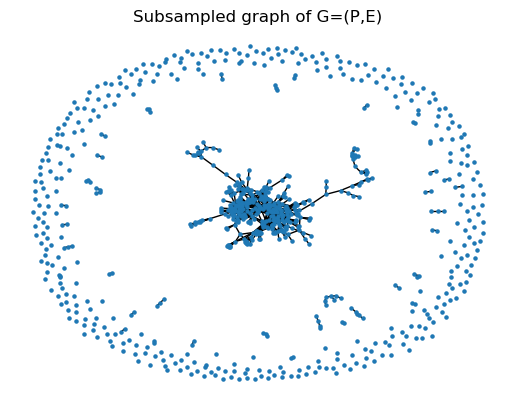

In [19]:
import matplotlib.pyplot as plt

# Assuming you have your subsampled graph 'subsampled_graph'
layout = nx.spring_layout(subsampled_graph)

# Draw the nodes
nx.draw_networkx_nodes(subsampled_graph, layout, node_size=5)

# Draw the edges (if needed)
nx.draw_networkx_edges(subsampled_graph, layout)

# Show the graph
plt.title("Subsampled graph of G=(P,E)") # 'P' stands for proteins, 'E' stand for edges
plt.axis('off')
plt.show()

As we can see in the graph above, there are some nodes (i.e. proteins) which are not connected to any other node. 
One of the reasons for that can be our divided data in graph G, that graph does not contain all of the edges in
our data set. Therefore, there can be some edges that does not exist in graph G.
Another reason can be the cause of our `subsampled` graph of G that we generated for faster graph plotting time.

## Creating text file that mapps index to unique protein ##

Before moving forward, we need to create `.txt` file that mapps unique `index`
for each unique `protein`. 
The reason behind that step -> prepare for creating `.edgelist` file for the graph embedding input.

In [20]:
# Helper function to make .txt that contains of 'index protein_id' rows
def write_graph_to_txt(graph, filename):
    with open(filename, 'w') as file:
        for index, node in enumerate(graph.nodes):
            file.write(f"{index} {node}\n")

In [21]:
output_file_ = "indx_to_protein.txt"

write_graph_to_txt(G_, output_file_)

## Write the graph G=(P,E) as `edgelist` ##

The next step is to convert (i.e. write) the graph `G=(P,E)` to
name `edgelist`, that is simply going to convert the graph into `.txt`
file with the next format:

`protein1` `protein2` 

`protein3` `protein4`

`protein5` `protein6`
        .
        .
        .

*Note* - we dont want to include the `combined_score` data in our `proteint_edgelist.txt`. Therefore, turn `data=Flase`

In [22]:
p_edgelist_ = nx.write_edgelist(G_, "STRING_PPI_11_0.edgelist", data=False)

In [23]:
# Load the node index mapping from "node_list.txt"
index_to_protein = {}
with open("indx_to_protein.txt", 'r') as node_list_file:
    for line in node_list_file:
        parts = line.strip().split(' ')
        if len(parts) == 2:
            index, protein = parts
            index_to_protein[protein] = index

# Create a new file to write the updated edge list for the data:
with open("STRING_PPI_11_0_.edgelist", 'w') as updated_file:
    with open("STRING_PPI_11_0.edgelist", 'r') as proteins_file:
        for line in proteins_file:
            source_protein, target_protein = line.strip().split(' ')
            source_index = index_to_protein.get(source_protein)
            target_index = index_to_protein.get(target_protein)
            if source_index is not None and target_index is not None:
                updated_file.write(f"{source_index} {target_index}\n")

## Graph Embedding ##

The next steps, will include downloading BioNEV repository from GitHub and making graph embeddings using
our proteins edgelist data structure we created above.

## Downloading BioNEV repository ##

The BioNEV repository is taken from GitHun linked:

https://github.com/xiangyue9607/BioNEV/tree/master

In [24]:
!git clone https://github.com/xiangyue9607/BioNEV.git

fatal: destination path 'BioNEV' already exists and is not an empty directory.


Next, move the STRING PPI edgelist to the `data` dir that located in `BioNEV` repository in order
to execute the graph embedding later on.

In [25]:
import shutil

source_file = "STRING_PPI_11_0_.edgelist"
destination_directory = "C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research/BioNEV/data"

shutil.copy(source_file, destination_directory)

'C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research/BioNEV/data\\STRING_PPI_11_0_.edgelist'

In [26]:
cd BioNEV

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV


The next step will be downloading the BioNEV repository and then downloading the `code` from it.

In [27]:
pip install -e.

Obtaining file:///C:/Users/gavvi/Desktop/Programming/Python/DeepLearning%20Research/BioNEV
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: bionev
    Found existing installation: bionev 0.1.0.dev0
    Uninstalling bionev-0.1.0.dev0:
      Successfully uninstalled bionev-0.1.0.dev0
  Running setup.py develop for bionev
Note: you may need to restart the kernel to use updated packages.


## Final step - Graph Embedding using GAE ##

Finally, we can generate the embedding for our PPI data set.

In [28]:
!bionev --input ./data/STRING_PPI_11_0_.edgelist \
       --output ./embeddings/STRING_PPI_11_0_embeddings.txt \
       --dimensions 500 \
       --method GAE \
       --epochs 800 \
       --task link-prediction \
       --eval-result-file eval_result.txt

######################################################################
Embedding Method: GAE, Evaluation Task: link-prediction
######################################################################
Original Graph: nodes: 16063 edges: 389682
Training Graph: nodes: 16063 edges: 312155
Loading training graph for learning embedding...
Graph Loaded...
Epoch: 0001 train_loss= 0.70204 train_acc= 0.00251 time= 10.11277
Epoch: 0101 train_loss= 0.45719 train_acc= 0.42561 time= 7.46074
Epoch: 0201 train_loss= 0.41140 train_acc= 0.55163 time= 7.61360
Epoch: 0301 train_loss= 0.39203 train_acc= 0.55422 time= 9.91761
Epoch: 0401 train_loss= 0.38518 train_acc= 0.55972 time= 7.58276
Epoch: 0501 train_loss= 0.38140 train_acc= 0.55640 time= 7.55426
Epoch: 0601 train_loss= 0.37903 train_acc= 0.55745 time= 7.96345
Epoch: 0701 train_loss= 0.37775 train_acc= 0.55773 time= 7.83173
Optimization Finished!
(16063, 500)
Embedding Learning Time: 6503.92 s
Nodes with embedding: 16063
Begin evaluation...
######### L

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
targets is deprecated, use labels instead
2023-11-01 16:45:26.277158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 16:45:26.292088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-11-01 16:45:26.486551: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1032079876 exceeds 10% of free system memory.
2023-11-01 16:45:26.670178: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1032079876 exceeds 10% of free system memory.
2023-11-01 16:45:26.670202: W tensorf

## Retrieve proteins actual id back to the embedding .txt file ##

The final step after we generated the embeddings for our proteins, is to get the proteins to thier
actual format before we changed that to `int` format for our task.

For example: for the protein with the id number `7539` will turn into -> `9606.ENSP00000350012`


In [4]:
cd embeddings

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV\embeddings


In [5]:
import shutil

source_file = "STRING_PPI_11_0_embeddings.txt"
destination_directory = "C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research"

shutil.copy(source_file, destination_directory)

'C:/Users/gavvi/Desktop/Programming/Python/DeepLearning Research\\STRING_PPI_11_0_embeddings.txt'

In [6]:
import os

os.chdir(destination_directory)
current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research


In [7]:
def replace_mapped_ids(embeddings_file, node_list_file):
    """
    The function takes the embedding file and return the proteins integer id to their original
    id as originated from STRING PPI dataset
    """
    
    # Create a dictionary to map mapped IDs to real protein IDs
    id_mapping = {}

    with open(node_list_file, 'r') as node_list:
        for line in node_list:
            mapped_id, real_id = line.strip().split()
            id_mapping[mapped_id] = real_id

    # Read the embeddings file, replace mapped IDs with real IDs, and write to a new file
    with open(embeddings_file, 'r') as embeddings:
        lines = embeddings.readlines()

    with open(embeddings_file, 'w') as embeddings:
        for line in lines:
            if not line.strip():  # Skip empty lines
                continue
            tokens = line.strip().split()
            mapped_id = tokens[0]
            if mapped_id in id_mapping:
                real_id = id_mapping[mapped_id]
                tokens[0] = real_id
                new_line = ' '.join(tokens)
                embeddings.write(new_line + '\n')
            else:
                embeddings.write(line)

In [8]:
# Usage example
embeddings_file = "STRING_PPI_11_0_embeddings.txt"
node_list_file = "indx_to_protein.txt"
replace_mapped_ids(embeddings_file, node_list_file)

The next step is to convert the `.txt` file into `.csv` file, so we can visualize our embedding `.txt` file in more
informative way with the format:

`protein1_id` _ `protein1_embedding_vector`

`protein2_id` _ `protein2_embedding_vector`

`protein3_id` _ `protein3_embedding_vector`

....

In [9]:
import csv

def create_csv_from_embeddings(embeddings_file, csv_output_file):
    """
    The function takes '.txt' file of proteins and their corresponding 
    embeddings vectors, and turns that into '.csv' file
    """
    data = []
    
    # Read the modified embeddings file and extract the data
    with open(embeddings_file, 'r') as embeddings:
        for line in embeddings:
            line = line.strip()
            if line:
                values = line.split()
                data.append(values)

    # Write the data to a CSV file
    with open(csv_output_file, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        
        # Write the header (column names)
        header = ["Protein"] + [f"Embedding_{i}" for i in range(1, len(data[0]))]
        csvwriter.writerow(header)

        # Write the data rows
        for values in data:
            protein_id, embeddings = values[0], values[1:]
            csvwriter.writerow([protein_id] + embeddings)

In [10]:
# Usage example
embeddings_file = "STRING_PPI_11_0_embeddings.txt"
csv_output_file = "output_embeddings.csv"
create_csv_from_embeddings(embeddings_file, csv_output_file)

## Graph Embedding using Struc2vev ##

After generating graph embeddingd for STRING PPI version 11.0 with GAE method, we will try also generating graph embeddings with `struc2vec` method.
The reason is due to the most accurate results of those two methods that shown in the article :

https://academic.oup.com/bioinformatics/article/36/4/1241/5581350?login=false

In [1]:
import os

current_directory = os.getcwd()
print("Current directory:", current_directory)

Current directory: C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research


In [2]:
cd BioNEV

C:\Users\gavvi\Desktop\Programming\Python\DeepLearning Research\BioNEV


In [ ]:
!bionev --input ./data/STRING_PPI_11_0_.edgelist \
       --output ./embeddings/STRING_PPI_11_0_s2vec_embeddings.txt \
       --dimensions 500 \
       --method struc2vec \
       --task link-prediction \
       --eval-result-file eval_result.txt